In [1]:
from keras.datasets import mnist
from keras.layers import Input, Conv2D, Conv2DTranspose, Dense, LeakyReLU, Flatten, Reshape, Activation
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [27]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [28]:
print('Shapes of data')
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

Shapes of data
x_train: (60000, 28, 28)
x_test: (10000, 28, 28)
y_train: (60000,)
y_test: (10000,)


In [29]:
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

Encoder and Decoder

In [6]:
input_dim = x_train.shape[1:] # This is the size of the input image that our auto-encoder will be working with
output_dim = input_dim # In an autoencoder, we want the output to be same as input (hence the name), and therefore
                       # the same size
conv_filter_nums = [32, 64, 64, 64]
conv_kernel_sizes = [3, 3, 3, 3]
conv_strides = [1, 2, 2, 1]

deconv_filter_nums = [64, 64, 32, 1]
deconv_kernel_sizes = [3, 3, 3, 3]
deconv_strides = [1, 2, 2, 1]

latent_dim = 2

In [7]:
encoder_input = Input(shape=input_dim, name='encoder_input')
x = encoder_input

assert len(conv_filter_nums) == len(conv_kernel_sizes) == len(conv_strides)
n_conv_layers = len(conv_filter_nums)

for i in range(n_conv_layers):
    conv_layer = Conv2D(filters=conv_filter_nums[i],
                        kernel_size=conv_kernel_sizes[i],
                        strides=conv_strides[i],
                        padding='same',
                        name='encoder_conv_' + str(i))
    x = conv_layer(x)
    x = LeakyReLU()(x)
    
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)

encoder_output = Dense(latent_dim, name='encoder_output')(x)

encoder = Model(encoder_input, encoder_output)

W0903 20:28:25.340770 139737946167104 deprecation_wrapper.py:119] From /home/vaibhav/projects/GDL_code/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 20:28:25.363704 139737946167104 deprecation_wrapper.py:119] From /home/vaibhav/projects/GDL_code/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 20:28:25.391804 139737946167104 deprecation_wrapper.py:119] From /home/vaibhav/projects/GDL_code/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [8]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

In [9]:
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)

assert len(deconv_filter_nums) == len(deconv_kernel_sizes) == len(deconv_strides)
n_deconv_layers = len(deconv_filter_nums)

for i in range(n_deconv_layers):
    deconv_layer = Conv2DTranspose(filters=deconv_filter_nums[i],
                                   kernel_size=deconv_kernel_sizes[i],
                                   strides=deconv_strides[i],
                                   padding='same',
                                   name='decoder_conv_' + str(i))
    x = deconv_layer(x)
    if i < n_deconv_layers - 1:
        x = LeakyReLU()(x)
    else:
        x = Activation('sigmoid')(x)

decoder_output = x                
decoder = Model(decoder_input, decoder_output)

In [10]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 64)        0         
__________

In [11]:
autoencoder_input = encoder_input
autoencoder_output = decoder(encoder_output)

autoencoder = Model(autoencoder_input, autoencoder_output)

In [12]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

In [13]:
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])

optimizer = Adam(lr=0.0005)

autoencoder.compile(optimizer='adam', loss=r_loss)

W0903 20:28:42.938951 139737946167104 deprecation_wrapper.py:119] From /home/vaibhav/projects/GDL_code/env/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [15]:
batch_size = 8
num_epochs = 20

model_filename = 'autoencoder.hdf5'

callbacks = [ModelCheckpoint(filepath=model_filename + '.hdf5', monitor='loss', verbose=1), 
             EarlyStopping(monitor='loss', patience=3, verbose=1)]

In [ ]:
history = autoencoder.fit(x=x_train,
                          y=x_train, 
                          batch_size=batch_size,
                          epochs=num_epochs,
                          callbacks=callbacks,
                          shuffle=True)

Epoch 1/20
60000/60000 [==============================] - 520s 9ms/step - loss: 0.0491

Epoch 00001: saving model to autoencoder_2.hdf5
Epoch 2/20
60000/60000 [==============================] - 516s 9ms/step - loss: 0.0447

Epoch 00002: saving model to autoencoder_2.hdf5
Epoch 3/20
60000/60000 [==============================] - 542s 9ms/step - loss: 0.0436 0s - l

Epoch 00003: saving model to autoencoder_2.hdf5
Epoch 4/20
60000/60000 [==============================] - 555s 9ms/step - loss: 0.0430

Epoch 00004: saving model to autoencoder_2.hdf5
Epoch 5/20
60000/60000 [==============================] - 536s 9ms/step - loss: 0.0425

Epoch 00005: saving model to autoencoder_2.hdf5
Epoch 6/20
60000/60000 [==============================] - 537s 9ms/step - loss: 0.0422

Epoch 00006: saving model to autoencoder_2.hdf5
Epoch 7/20
60000/60000 [==============================] - 551s 9ms/step - loss: 0.0420

Epoch 00007: saving model to autoencoder_2.hdf5
Epoch 8/20
60000/60000 [=================

Plotting a random image to check if we are generating something relevant

In [16]:
autoencoder.load_weights(model_filename)

W0903 20:29:52.465653 139737946167104 deprecation_wrapper.py:119] From /home/vaibhav/projects/GDL_code/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0903 20:29:52.466467 139737946167104 deprecation_wrapper.py:119] From /home/vaibhav/projects/GDL_code/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [25]:
img_to_plot_index = np.random.randint(x_train.shape[0])

img_to_plot = x_train[img_to_plot_index]
generated_image = autoencoder.predict(np.expand_dims(img_to_plot, 0))[0]

img_to_plot = np.squeeze(img_to_plot)
generated_image = np.squeeze(generated_image)

print(img_to_plot.shape)
print(generated_image.shape)

(28, 28)
(28, 28)


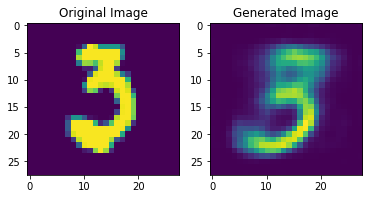

In [26]:
fig = plt.figure()

plt.subplot(121)
plt.title('Original Image')
plt.imshow(img_to_plot)

plt.subplot(122)
plt.title('Generated Image')
plt.imshow(generated_image)

plt.show()

Let's say what the latent dimension space looks like

In [32]:
num_pts_to_show = 5000
random_indexes = np.random.choice( range(len(x_test)), num_pts_to_show )

input_imgs = x_test[random_indexes]
labels = y_test[random_indexes]

pred_coords = encoder.predict(input_imgs)

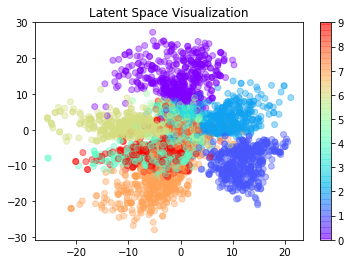

In [39]:
fig = plt.figure()

plt.title('Latent Space Visualization')
plt.scatter(pred_coords[:, 0], pred_coords[:, 1], c=labels, cmap='rainbow', alpha=0.4)
plt.colorbar()
plt.show()

plt.close(fig)

Let's try generating some new number images. That will be a good test for our decoder

In [40]:
num_digits_to_show = 10

random_coords = np.random.normal(loc=0.0, scale=15, size=(num_digits_to_show, 2))
generated_digit_imgs = decoder.predict(random_coords)

generated_digit_imgs.shape

(10, 28, 28, 1)

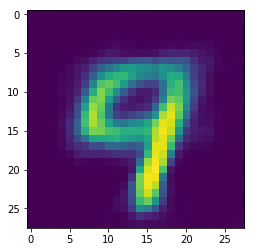

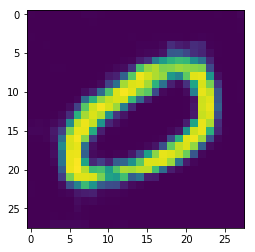

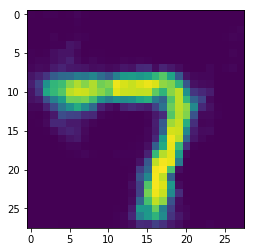

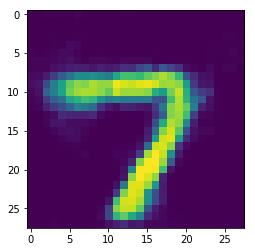

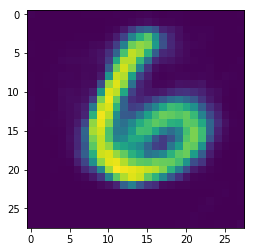

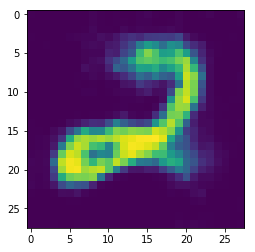

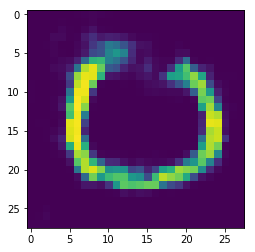

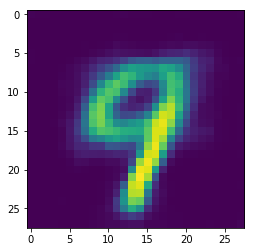

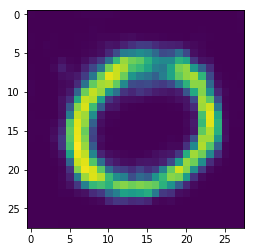

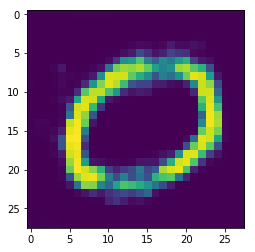

In [42]:
generated_digit_imgs = np.squeeze(generated_digit_imgs)

for digit in generated_digit_imgs:
    plt.imshow(digit)
    plt.show()